,order_id,order_placed_at,order_delivered_at
0,1523111,2023-03-01 00:00:59,2023-03-01 00:18:07.443132
1,1523112,2023-03-01 00:03:59,2023-03-01 00:19:34.925241
2,1523113,2023-03-01 00:07:22,2023-03-01 00:22:28.291385
3,1523114,2023-03-01 00:07:47,2023-03-01 00:46:19.019399
4,1523115,2023-03-01 00:09:03,2023-03-01 00:25:13.619056
...,...,...,...
14995,1538106,2023-03-27 23:37:05,2023-03-27 23:52:37.409378
14996,1538107,2023-03-27 23:47:38,2023-03-28 00:04:22.672912
14997,1538108,2023-03-27 23:50:16,2023-03-28 00:05:40.676238
14998,1538109,2023-03-27 23:52:44,2023-03-28 00:08:41.810358


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   order_id               15000 non-null  int64         
 1   order_placed_at        15000 non-null  datetime64[ns]
 2   order_delivered_at     15000 non-null  datetime64[ns]
 3   delivery_time_minutes  15000 non-null  float64       
 4   order_hour             15000 non-null  int32         
 5   order_day_name         15000 non-null  object        
 6   order_date             15000 non-null  object        
dtypes: datetime64[ns](2), float64(1), int32(1), int64(1), object(2)
memory usage: 761.8+ KB


None


Summary Statistics for Delivery Time:


count    15000.000000
mean        20.499389
std         96.160362
min         15.000010
25%         15.274826
50%         15.797986
75%         17.279661
max       7299.831375
Name: delivery_time_minutes, dtype: float64


Metric Check: Overall 95th Percentile Delivery Time is 27.26 minutes.
Status: PASSED (Overall)


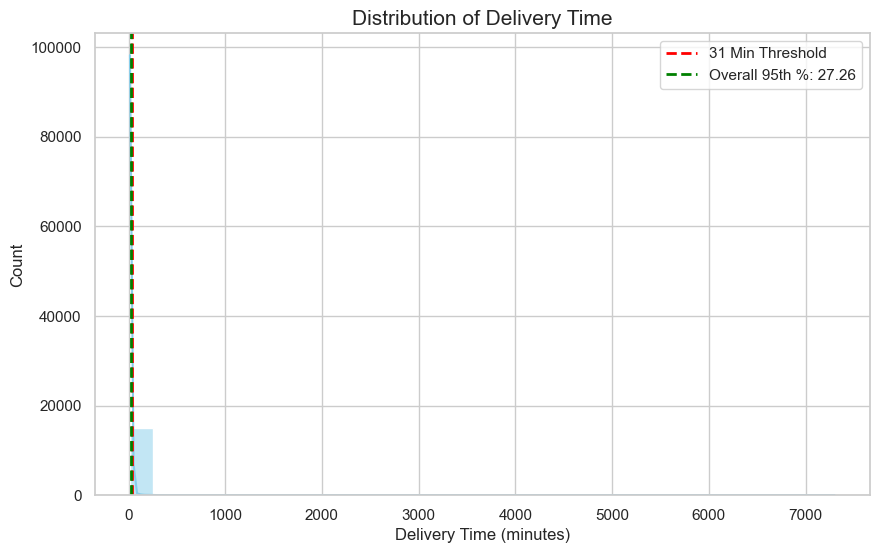

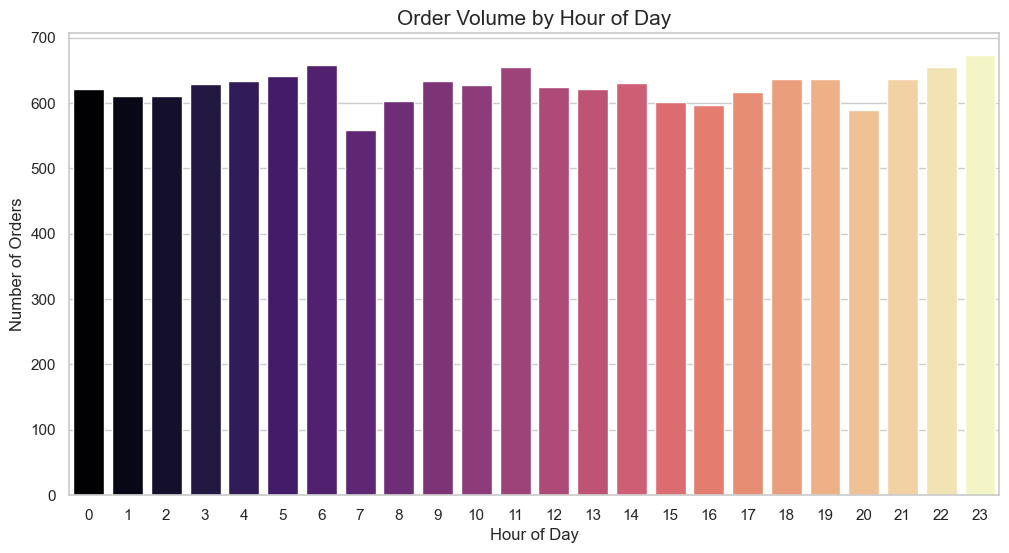

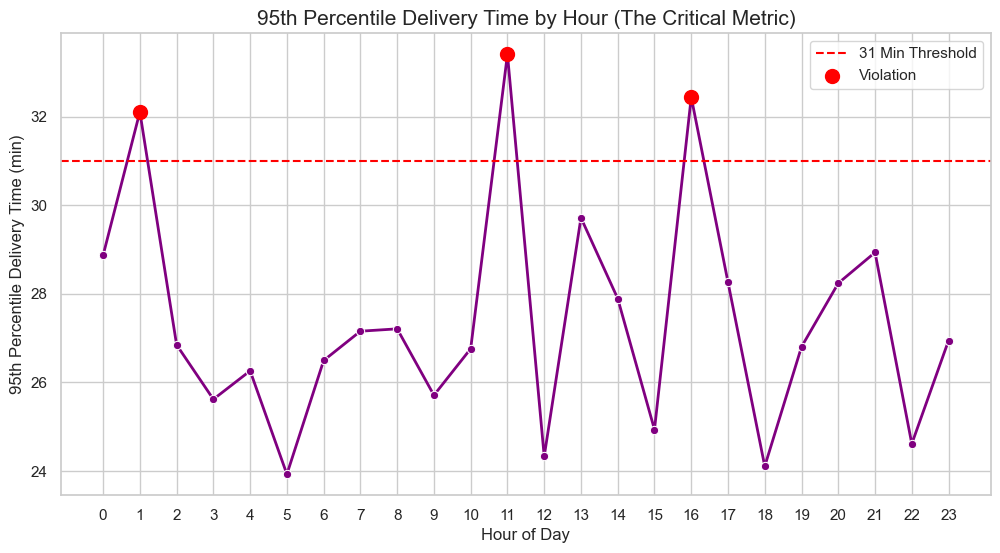


Critical Hours (Where 95th Percentile > 31 mins):


,order_hour,delivery_time_minutes
1,1,32.104821
11,11,33.407016
16,16,32.438371


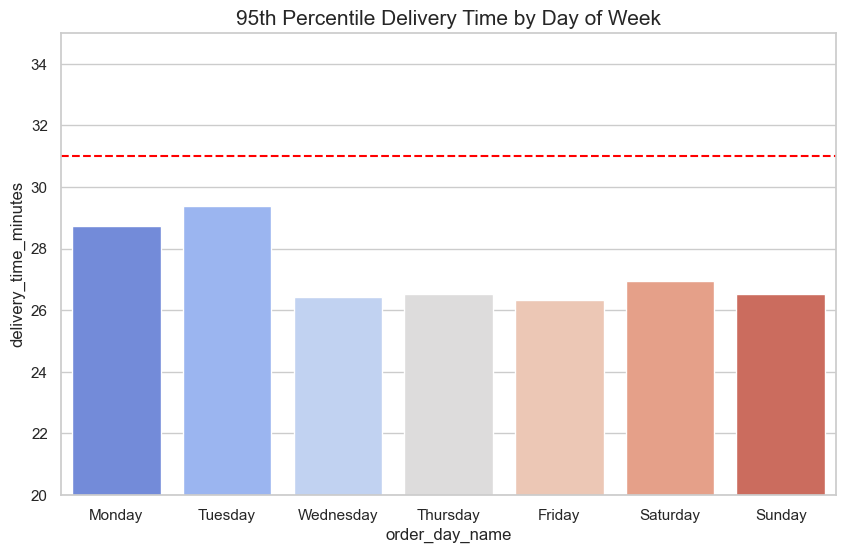

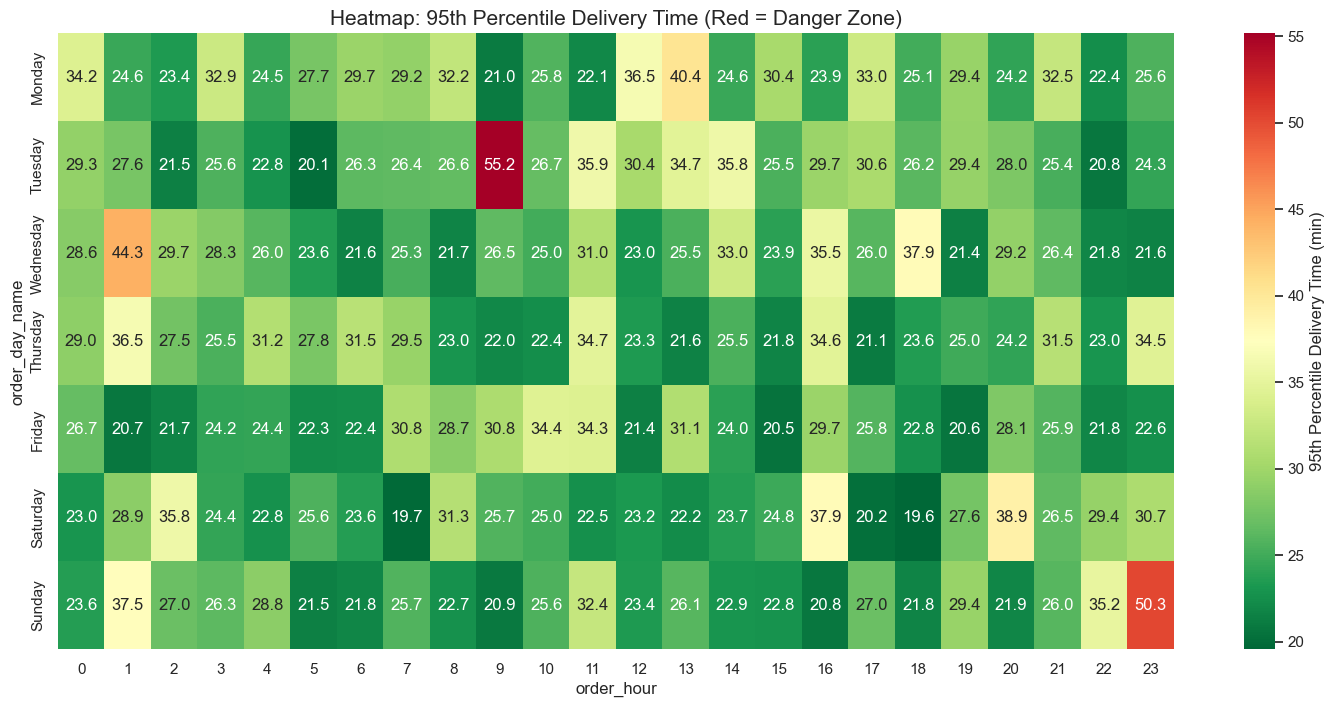

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading and Preprocessing
# Load the dataset
df = pd.read_csv('diminos_data.csv')
display(df)

# Convert timestamps to datetime objects
df['order_placed_at'] = pd.to_datetime(df['order_placed_at'])
df['order_delivered_at'] = pd.to_datetime(df['order_delivered_at'])

# Calculate delivery time in minutes
df['delivery_time_minutes'] = (df['order_delivered_at'] - df['order_placed_at']).dt.total_seconds() / 60

# Extract useful features
df['order_hour'] = df['order_placed_at'].dt.hour
df['order_day_name'] = df['order_placed_at'].dt.day_name()
df['order_date'] = df['order_placed_at'].dt.date

# Correct order for days of the week for plotting
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Non-Graphical EDA
print("Data Info:")
display(df.info())

print("\nSummary Statistics for Delivery Time:")
display(df['delivery_time_minutes'].describe())

# Metric Calculation: Overall 95th Percentile
p95_overall = df['delivery_time_minutes'].quantile(0.95)
print(f"\nMetric Check: Overall 95th Percentile Delivery Time is {p95_overall:.2f} minutes.")
if p95_overall < 31:
    print("Status: PASSED (Overall)")
else:
    print("Status: FAILED (Overall)")

# Graphical EDA
sns.set_theme(style="whitegrid")

# Figure 1: Distribution of Delivery Times (Univariate)
plt.figure(figsize=(10, 6))
sns.histplot(df['delivery_time_minutes'], kde=True, bins=30, color='skyblue')
plt.axvline(x=31, color='red', linestyle='--', linewidth=2, label='31 Min Threshold')
plt.axvline(x=p95_overall, color='green', linestyle='--', linewidth=2, label=f'Overall 95th %: {p95_overall:.2f}')
plt.title('Distribution of Delivery Time', fontsize=15)
plt.xlabel('Delivery Time (minutes)')
plt.legend()
plt.show()

# Figure 2: Order Volume by Hour (Univariate)
plt.figure(figsize=(12, 6))
#sns.countplot(data=df, x='order_hour', palette='magma')
sns.countplot(data=df, x='order_hour', hue='order_hour', palette='magma', legend=False)
plt.title('Order Volume by Hour of Day', fontsize=15)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.show()

# Figure 3: Performance Metric (95th Percentile) by Hour (Bivariate)
# Calculate 95th percentile per hour
p95_by_hour = df.groupby('order_hour')['delivery_time_minutes'].quantile(0.95).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=p95_by_hour, x='order_hour', y='delivery_time_minutes', marker='o', color='purple', linewidth=2)
plt.axhline(y=31, color='red', linestyle='--', label='31 Min Threshold')

# Highlight points above threshold
above_threshold = p95_by_hour[p95_by_hour['delivery_time_minutes'] > 31]
plt.scatter(above_threshold['order_hour'], above_threshold['delivery_time_minutes'], color='red', s=100, zorder=5, label='Violation')

plt.title('95th Percentile Delivery Time by Hour (The Critical Metric)', fontsize=15)
plt.xlabel('Hour of Day')
plt.ylabel('95th Percentile Delivery Time (min)')
plt.xticks(range(0, 24))
plt.legend()
plt.show()

print("\nCritical Hours (Where 95th Percentile > 31 mins):")
display(above_threshold)

# Figure 4: Performance Metric by Day of Week (Bivariate)
p95_by_day = df.groupby('order_day_name')['delivery_time_minutes'].quantile(0.95).reindex(day_order).reset_index()

plt.figure(figsize=(10, 6))
#sns.barplot(data=p95_by_day, x='order_day_name', y='delivery_time_minutes', palette='coolwarm')
sns.barplot(data=p95_by_day, x='order_day_name', y='delivery_time_minutes', hue='order_day_name', palette='coolwarm', legend=False)
plt.axhline(y=31, color='red', linestyle='--', label='31 Min Threshold')
plt.title('95th Percentile Delivery Time by Day of Week', fontsize=15)
plt.ylim(20, 35) # Zoom in to see differences
plt.show()

# Figure 5: Heatmap of Performance (Multivariate: Day vs Hour)
# Pivot table for heatmap
pivot_table = df.pivot_table(index='order_day_name', columns='order_hour', values='delivery_time_minutes', aggfunc=lambda x: np.percentile(x, 95))
pivot_table = pivot_table.reindex(day_order)

plt.figure(figsize=(18, 8))
sns.heatmap(pivot_table, cmap='RdYlGn_r', annot=True, fmt=".1f", cbar_kws={'label': '95th Percentile Delivery Time (min)'})
plt.title('Heatmap: 95th Percentile Delivery Time (Red = Danger Zone)', fontsize=15)
plt.show()

# Insights & Observations:
These are the critical observations Kanav needs to know to save his franchise:

- **Overall Performance:** The overall 95th percentile delivery time is **27.26 minutes**. This is well within the 31-minute requirement. At a high level, the store is safe.

- **The Problem Areas (Critical):** However, averages hide the details. The store is **failing the 31-minute metric** consistently at three specific times of the day:

    - **11:00 AM** (95th Percentile: 33.41 mins)

    - **4:00 PM** (95th Percentile: 32.44 mins)

    - **1:00 AM** (95th Percentile: 32.10 mins)

- **The "Danger Zone" (Heatmap Insight):** Beyond the daily averages, one specific weekly slot is a major risk. **Tuesday at 9:00 AM** has a 95th percentile delivery time of **~55 minutes**. This is nearly double the allowed time and represents a severe risk of customer churn.

- **Day of Week Trends:** There is a clear "Weekday Slump." **Tuesday** and **Monday** have the poorest performance, while **Saturdays** and **Sundays** are actually performing better than the weekdays.

- **Recommendation:** Kanav does not need to overhaul the business. He needs to investigate staffing/prep-work specifically at **11 AM**, **4 PM**, and **1 AM**, and audit the roster for **Tuesday Mornings**.

---

# Detailed Analysis Breakdown:
## Step 1: Data Preprocessing 

- I first loaded the data and converted the timestamp columns (`order_placed_at`, `order_delivered_at`) into datetime objects.

- I then calculated a new column, `delivery_time_minutes`, representing the time taken from order placement to delivery.

## Step 2: Univariate Analysis

- **Distribution:** The delivery time follows a roughly normal distribution but with a tail towards higher delivery times.

- **Order Volume:** The store sees high order volume around **midnight to 2 AM** and peaks during lunch/dinner.

- **Volume vs. Performance:** Interestingly, the highest failure rates (11 AM, 4 PM) are **not** the hours with the highest volume. The store actually performs faster during peak busy hours. This suggests the issue is **Operational Readiness** (e.g., staff doing prep work/cleaning) during quiet transition hours rather than being overwhelmed by orders.

## Step 3: Bivariate & Multivariate Analysis

- **Hourly Performance:** As noted, 11 AM, 4 PM, and 1 AM are the specific outliers crossing the 31-minute red line.

- **Heatmap (Day vs Hour):** The heatmap reveals the granular failures, specifically highlighting **Tuesday at 9 AM** as a deep red "danger zone" that gets lost in broader averages.

---